# Data Exploration of Dallas Crime Reports with Dask

Where does Dask fit into the ecosystem?




By Sam Foo and (Linjie Huang)

Source: https://www.dallasopendata.com/Public-Safety/Police-Incidents/tbnj-w5hb

## Dask Cluster

### What is Dask?

"_Dask is a flexible parallel computing library for analytic computing._"

http://dask.pydata.org/en/latest/index.html

Good:

 * Introduces a familiar API in a distributed environment
 * Trivial to install
 * Open source and in active development. No vendor lock-in
 * Fine control over requested resources from each worker

Bad:

 * Default installations are out-of-date (e.g. installs pandas 0.19 by default; 0.23 is almost released)
 * Python path needs to be same across all workers
 * Relies on Paramiko - probably better off deploying on Kubernetes with Jupyter Notebook
 * Some operations involving shuffling parallelize poorly (e.g. join on column)

## Manual Setup

* Using 1 scheduler and 3 worker nodes (1 scheduler and 1 worker on same server)
* Done on a cheap $5/mo VPS (1 virtualized CPU core, 1GB RAM)
* Lots of potential for automation via Ansible

### Prerequisites

1. Local computer can access scheduler
2. Scheduler can access worker nodes via SSH
3. Miniconda installed on all nodes: `wget https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh`
4. Run the install script: `bash Miniconda3-latest-Linux-x86_64.sh`
5. Install distributed Dask: `conda install dask distributed -c conda-forge`
6. Start `dask-scheduler` then run `dask-worker tcp://SCHEDULER_IP:8786` on workers

### Libraries on Scheduler

1. Update to current library versions: `conda update pandas`
    
2. Install other libraries for plotting: `conda install matplotlib pytables snakeviz pillow`

3. To see execution graphs, do **not** use `conda install graphviz`.

   Instead use `sudo apt install graphviz` then `pip install graphviz`

## Manual Setup

* Using 1 scheduler and 3 worker nodes (1 scheduler and 1 worker on same server)
* Done on a cheap $5/mo VPS (1 virtualized CPU core, 1GB RAM)
* Lots of potential for automation via Ansible

### Prerequisites

1. Local computer can access scheduler
2. Scheduler can access worker nodes via SSH
3. Miniconda installed on all nodes: `wget https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh`
4. Start `dask-scheduler` then run `dask-worker tcp://SCHEDULER_IP:8786` on workers

```
$ dask-scheduler
distributed.scheduler - INFO - -----------------------------------------------
distributed.scheduler - INFO - Clear task state
distributed.scheduler - INFO -   Scheduler at:  tcp://SCHEDULER_IP:8786
distributed.scheduler - INFO -       bokeh at:                     :8787
distributed.scheduler - INFO - Local Directory:    /tmp/scheduler-qa45f_4a
distributed.scheduler - INFO - -----------------------------------------------
distributed.scheduler - INFO - Register tcp://WORKER1_IP:38647
distributed.scheduler - INFO - Starting worker compute stream, tcp://WORKER1_IP:38647
distributed.scheduler - INFO - Register tcp://WORKER2_IP:45735
distributed.scheduler - INFO - Starting worker compute stream, tcp://WORKER2_IP:45735
distributed.scheduler - INFO - Register tcp://SCHEDULER_IP:40453
distributed.scheduler - INFO - Starting worker compute stream, tcp://SCHEDULER_IP:40453
```

## How to run Jupyter Notebook headless?

Recall Jupyter Notebooks serves on localhost:8888 by default. Running on 0.0.0.0 is a bad idea, and reverse proxy is troublesome.

```
$ jupyter notebook
[I 03:09:06.812 NotebookApp] Writing notebook server cookie secret to /run/user/1000/jupyter/notebook_cookie_secret
[I 03:09:07.249 NotebookApp] Serving notebooks from local directory: /home/sfoo
[I 03:09:07.250 NotebookApp] 0 active kernels
[I 03:09:07.250 NotebookApp] The Jupyter Notebook is running at:
[I 03:09:07.250 NotebookApp] http://localhost:8888/?token=0ea9ee515517ecaae29d71684da5008359da22c4cce9f109
[I 03:09:07.250 NotebookApp] Use Control-C to stop this server and shut down all kernels (twice to skip confirmation).
[W 03:09:07.250 NotebookApp] No web browser found: could not locate runnable browser.
```

### Solution: SSH Tunnel

`ssh sfoo@SCHEDULER_IP -L 8889:localhost:8888`

Securely access the remote server from local computer on browser with localhost:8889 then paste token from above.


In [1]:
from dask.distributed import Client

import json

# Setup connection to cluster through scheduler
client = Client('SCHEDULER_IP:8786', set_as_default=True)
client

Client Scheduler: tcp://SCHEDULER_IP:8786 Dashboard: http://SCHEDULER_IP:8787/status,Cluster Workers: 3 Cores: 3 Memory: 4.14 GB


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import dask.dataframe as dd

pd.__version__

'0.22.0'

In [3]:
%%bash
# Can't just read_csv
# df = dd.read_csv('Police_Incidents.csv')
# ParserError: Error tokenizing data. C error: EOF inside string starting at line 256

sed -n '254p;256p' Police_Incidents.csv

276190-2015,2015,276190,276190C,276190-2015-01,3,40/01 - OTHER,RECOVERED OUT OF TOWN STOLEN VEHICLE (NO OFFENSE),NA,Outdoor Area Public/Private,N/A,4100,,EASTER AVE,4100 EASTER AVE,,75216,DALLAS,TX,2494016.47394762,6942648.93940507,4299,726,South Central,720,4,,,11/27/2015 12:00:00 AM,2015,November,Fri,17:03,331,11/27/2015 12:00:00 AM,2015,November,Fri,17:03,331,11/27/2015 05:03:00 PM,11/27/2015 05:03:00 PM,,11/27/2015 12:00:00 AM,11/27/2015 12:00:00 AM,2015,November,Fri,18:21,331,11/27/2015 05:03:37 PM,11/27/2015 05:03:36 PM,11/28/2015 12:11:05 AM,11/27/2015 05:05:25 PM,Victim,,FORT WORTH PD,,,,,3128 W BOLT ST,,76110,FORT WORTH,TX,,,C,,8575,"LOGAN,PAUL,ERVIN",7993,"WILLIAMS JR,THEOTIS",8575,8021,90936,B716,Investigations,Special Investigations / Auto Theft,Suspended,,,,,2600,,2600,NA-99999999-X5,No Offense,99999999,No Offense,FOUND,FOUND PROPERTY,NOT CODED,RECOVER OUT OF TOWN STOLEN,No,,No,,No,12/01/2015 12:57:41 PM,"4100 EASTER AVE
(32.702066, -96.791665)"


In [4]:
df = dd.read_csv('Cleaned_Incidents.csv')


In [5]:
# df.head()

"""
ValueError: ('Long error message', 'Mismatched dtypes found in `pd.read_csv`/`pd.read_table`.
+---------------------------------+--------+----------+
| Column                          | Found  | Expected |
+---------------------------------+--------+----------+
| Reporting Officer Badge No      | object | int64    |
| Responding Officer #1  Badge No | object | int64    |
| Responding Officer #2 Badge No  | object | float64  |
| Reviewing Officer Badge No      | object | int64    |
+---------------------------------+--------+----------+

The following columns also raised exceptions on conversion:

- Reporting Officer Badge No\n  ValueError(\'cannot convert float NaN to integer\',)
- Responding Officer #1  Badge No\n  ValueError(\'cannot convert float NaN to integer\',)
- Responding Officer #2 Badge No\n  ValueError("could not convert string to float: \'M235\'",)
- Reviewing Officer Badge No\n  ValueError(\'cannot convert float NaN to integer\',)

Usually this is due to dask\'s dtype inference failing, and\n*may* be fixed by specifying')
"""

'\nValueError: (\'Long error message\', \'Mismatched dtypes found in `pd.read_csv`/`pd.read_table`.\n+---------------------------------+--------+----------+\n| Column                          | Found  | Expected |\n+---------------------------------+--------+----------+\n| Reporting Officer Badge No      | object | int64    |\n| Responding Officer #1  Badge No | object | int64    |\n| Responding Officer #2 Badge No  | object | float64  |\n| Reviewing Officer Badge No      | object | int64    |\n+---------------------------------+--------+----------+\n\nThe following columns also raised exceptions on conversion:\n\n- Reporting Officer Badge No\n  ValueError(\'cannot convert float NaN to integer\',)\n- Responding Officer #1  Badge No\n  ValueError(\'cannot convert float NaN to integer\',)\n- Responding Officer #2 Badge No\n  ValueError("could not convert string to float: \'M235\'",)\n- Reviewing Officer Badge No\n  ValueError(\'cannot convert float NaN to integer\',)\n\nUsually this is d

In [6]:
df = dd.read_csv('Cleaned_Incidents.csv', dtype=object)

In [7]:
# After forcibly casting mixed types to object, this df loads
df.head()

,Unnamed: 0,Incident Number w/ Year,Year of Incident,Incident Number wo/ Year,Offense Service Number,Service Number ID,Watch,Call (911) Problem,Type of Incident,Penalty Class,...,UCR Offense Name,UCR Offense Description,Offense Type,Modus Operandi (MO),Family Offense,Hate Crime,Gang Related Offense,Victim Package,Drug Related Incident,Update Date
0,0,276285-2016,2016,276285,276285D,276285-2016-01,U,11R - BURG OF RES,BURGLARY OF HABITATION - FORCED ENTRY,F2,...,BURGLARY-RESIDENCE,BURGLARY,PART1,UNKNOWN SUSPECT GAINED FORCED ENTRY TO APT AND...,No,NaN,No,NaN,No,11/26/2016 08:29:01 PM
1,1,277474-2016,2016,277474,277474D,277474-2016-01,1,7X - MAJOR ACCIDENT,ACCIDENT INV DAMAGE TO VEHICLE,MB,...,ACCIDENT MV,MOTOR VEHICLE ACCIDENT,PART2,SUSPECT HIT COMP'S VEHICLE AND FLED SCENE.,No,NaN,No,NaN,No,12/02/2016 09:00:04 PM
2,2,276593-2016,2016,276593,276593D,276593-2016-01,3,55 - TRAFFIC STOP,FOUND PROPERTY (NO OFFENSE),NaN,...,FOUND,FOUND PROPERTY,NOT CODED,FOUND PROPERTY,No,NaN,No,NaN,No,11/21/2016 06:43:35 AM
3,3,000010-2015,2015,10,000010C,000010-2015-01,3,20 - ROBBERY,BURGLARY OF BUILDING - FORCED ENTRY,FS,...,BURGLARY-BUSINESS,BURGLARY,PART1,"UNK SUSP RAMED VEHICLE INTO BUSINESS, CAUSING ...",No,NaN,UNK,NaN,UNK,01/12/2015 01:04:07 PM
4,4,277049-2016,2016,277049,277049D,277049-2016-01,1,PSE/09 - THEFT,"THEFT OF PROP > OR EQUAL $2,500 BUT <$30K- NOT...",FS,...,OTHER THEFTS,THEFT,PART1,UNKNOWN SUSPECT REMOVED COMPLAINANT WATCH FROM...,No,NaN,No,NaN,No,11/23/2016 11:51:58 AM


In [8]:
df.dtypes

Unnamed: 0                        object
Incident Number w/ Year           object
Year of Incident                  object
Incident Number wo/ Year          object
Offense Service Number            object
Service Number ID                 object
Watch                             object
Call (911) Problem                object
Type of Incident                  object
Penalty Class                     object
Type of Location                  object
Type of Property                  object
Street Block                      object
Street Direction                  object
Street Name                       object
Incident Address                  object
Apartment Number                  object
Zip Code                          object
City                              object
State                             object
 X Coordinate                     object
 Y Coordinate                     object
Reporting Area                    object
Beat                              object
Division        

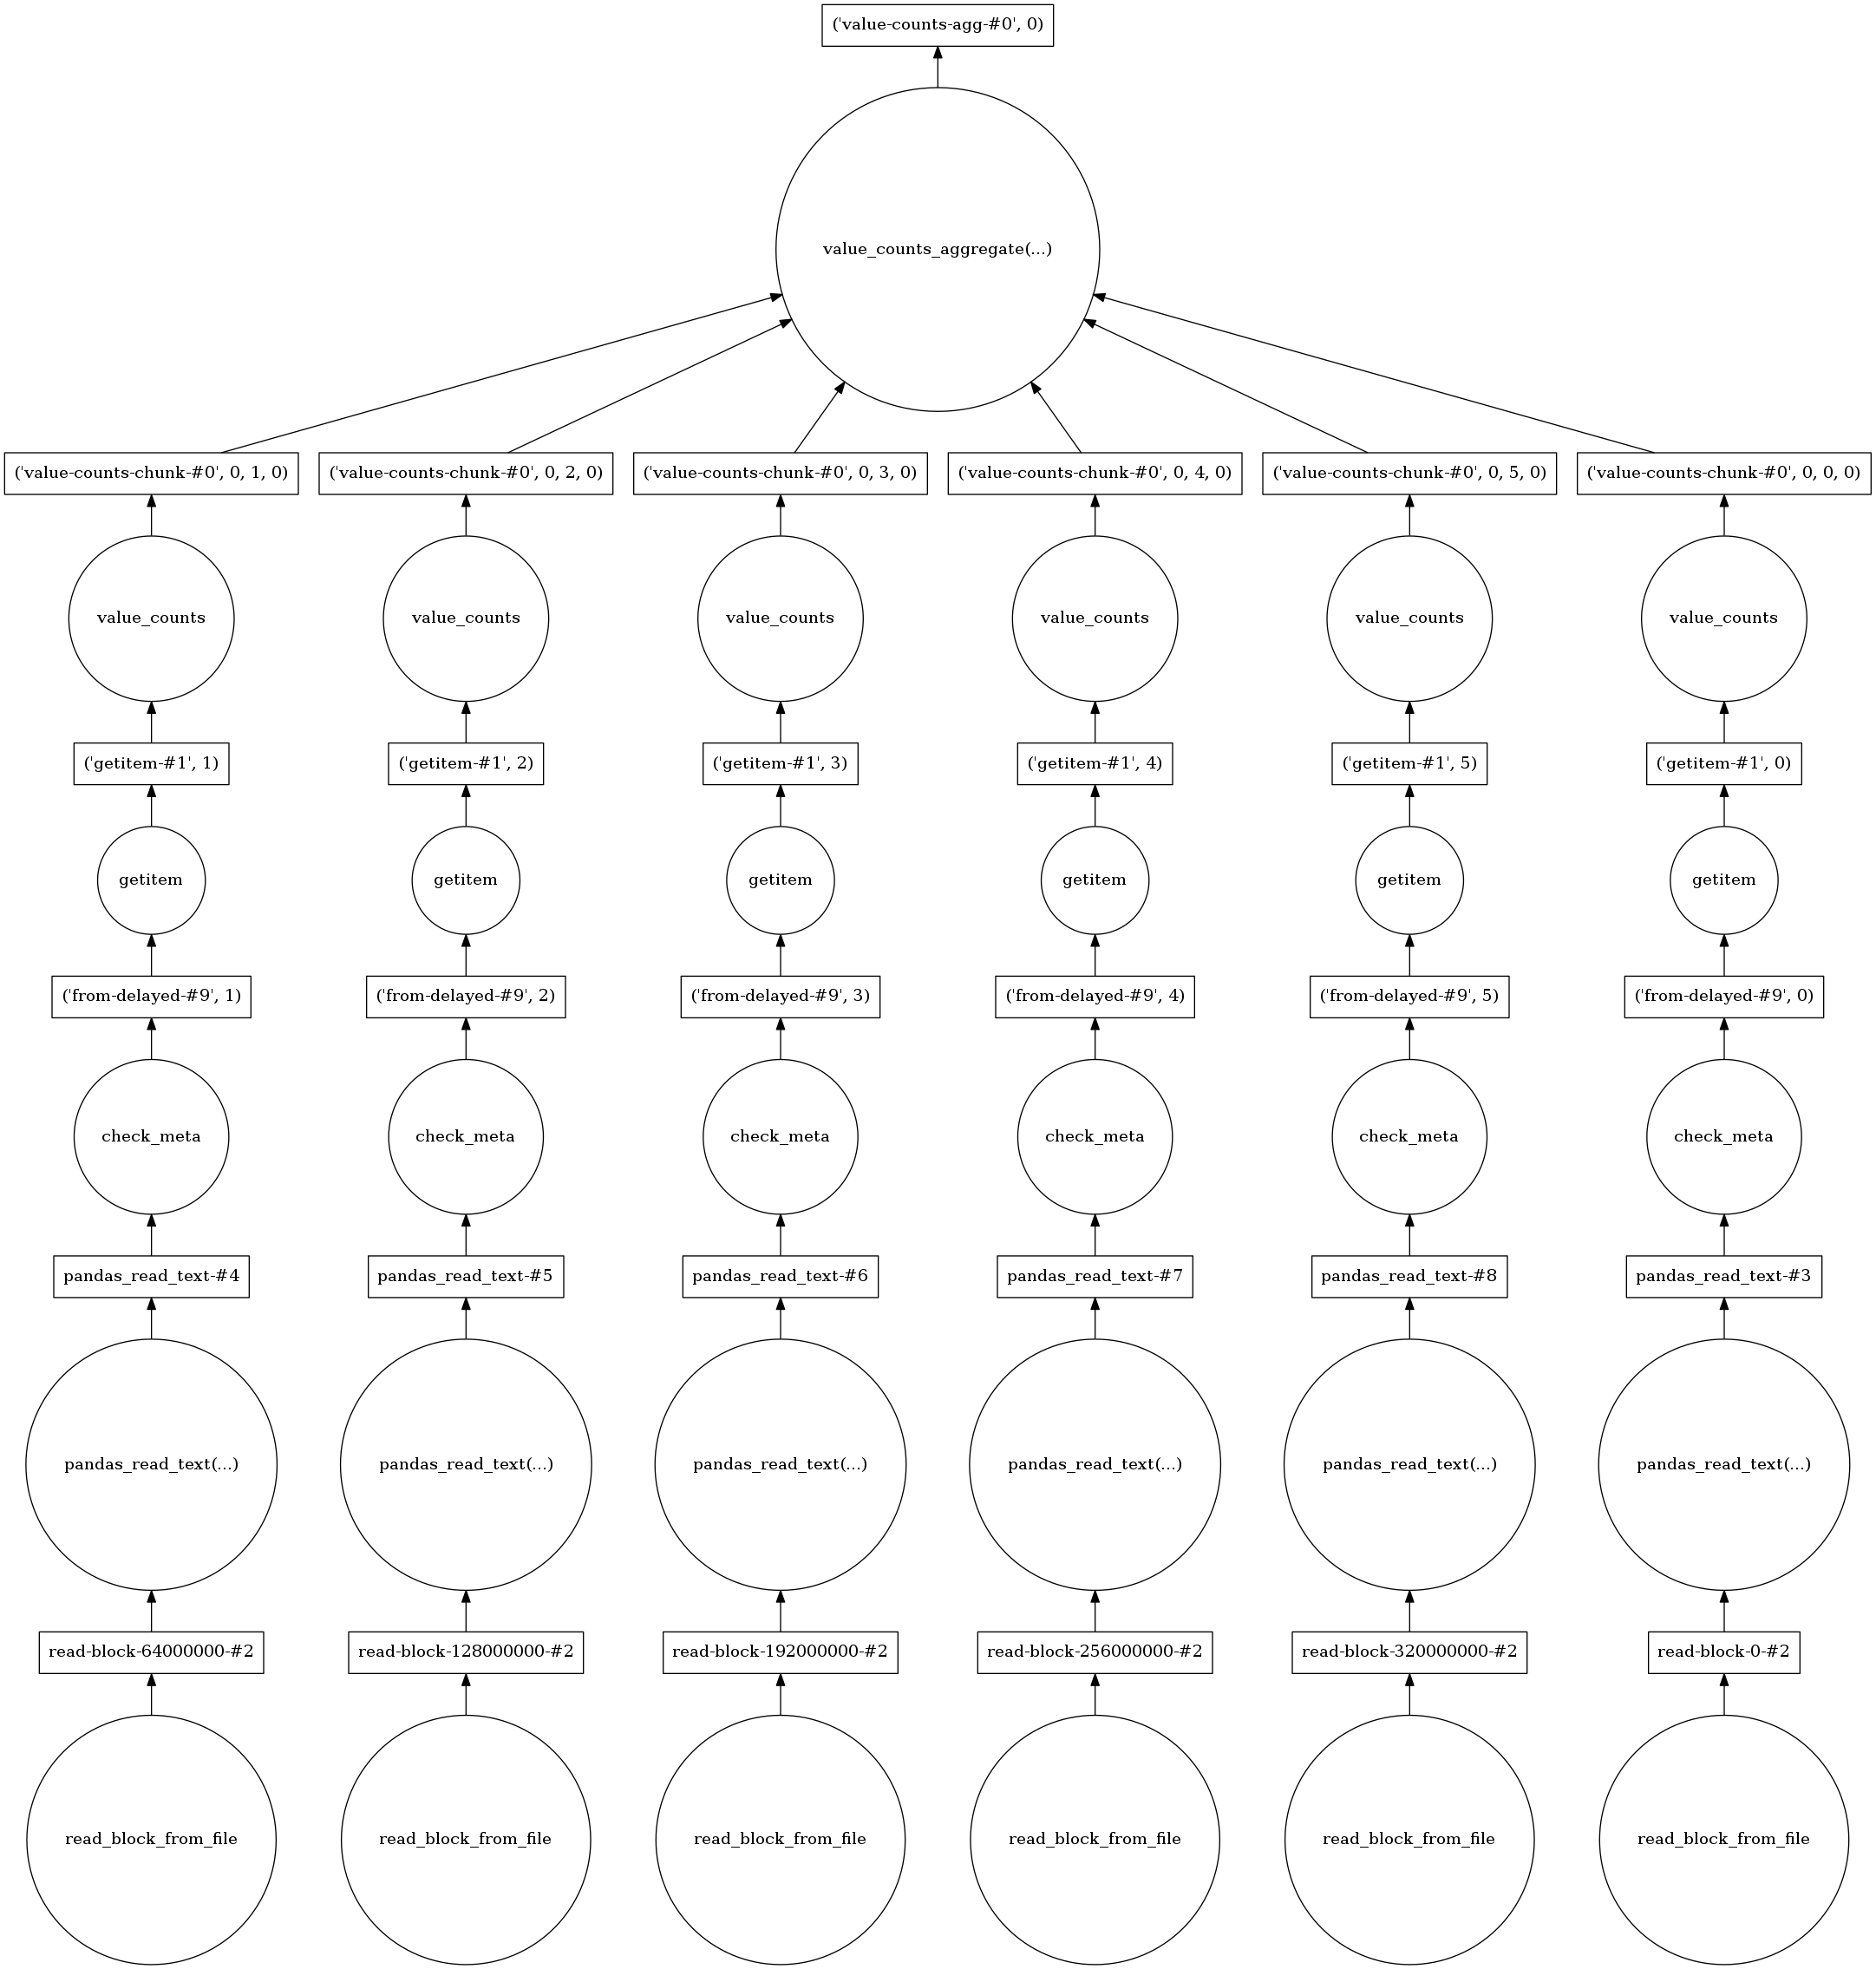

In [9]:
# Similarity to Spark - lazy evaluation
# value_counts() -> transformation
# compute() - >
df['UCR Offense Name'].value_counts().visualize()

In [10]:
# Uniform Crime Reporting - Most common crimes in Dallas?
ucr = df['UCR Offense Name'].value_counts().compute()

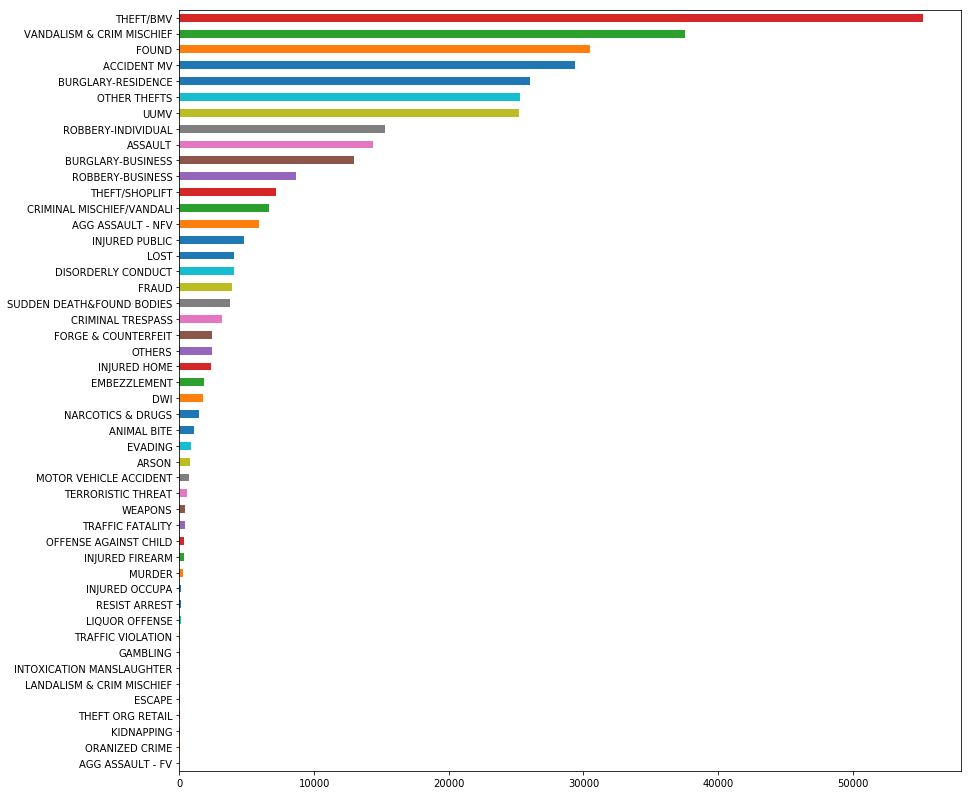

In [11]:
ucr[::-1].plot(kind='barh', figsize=(14,14))